# **Lecture 2 Laborarory Session**
## Let's add some practical details to use convolutional layers

# 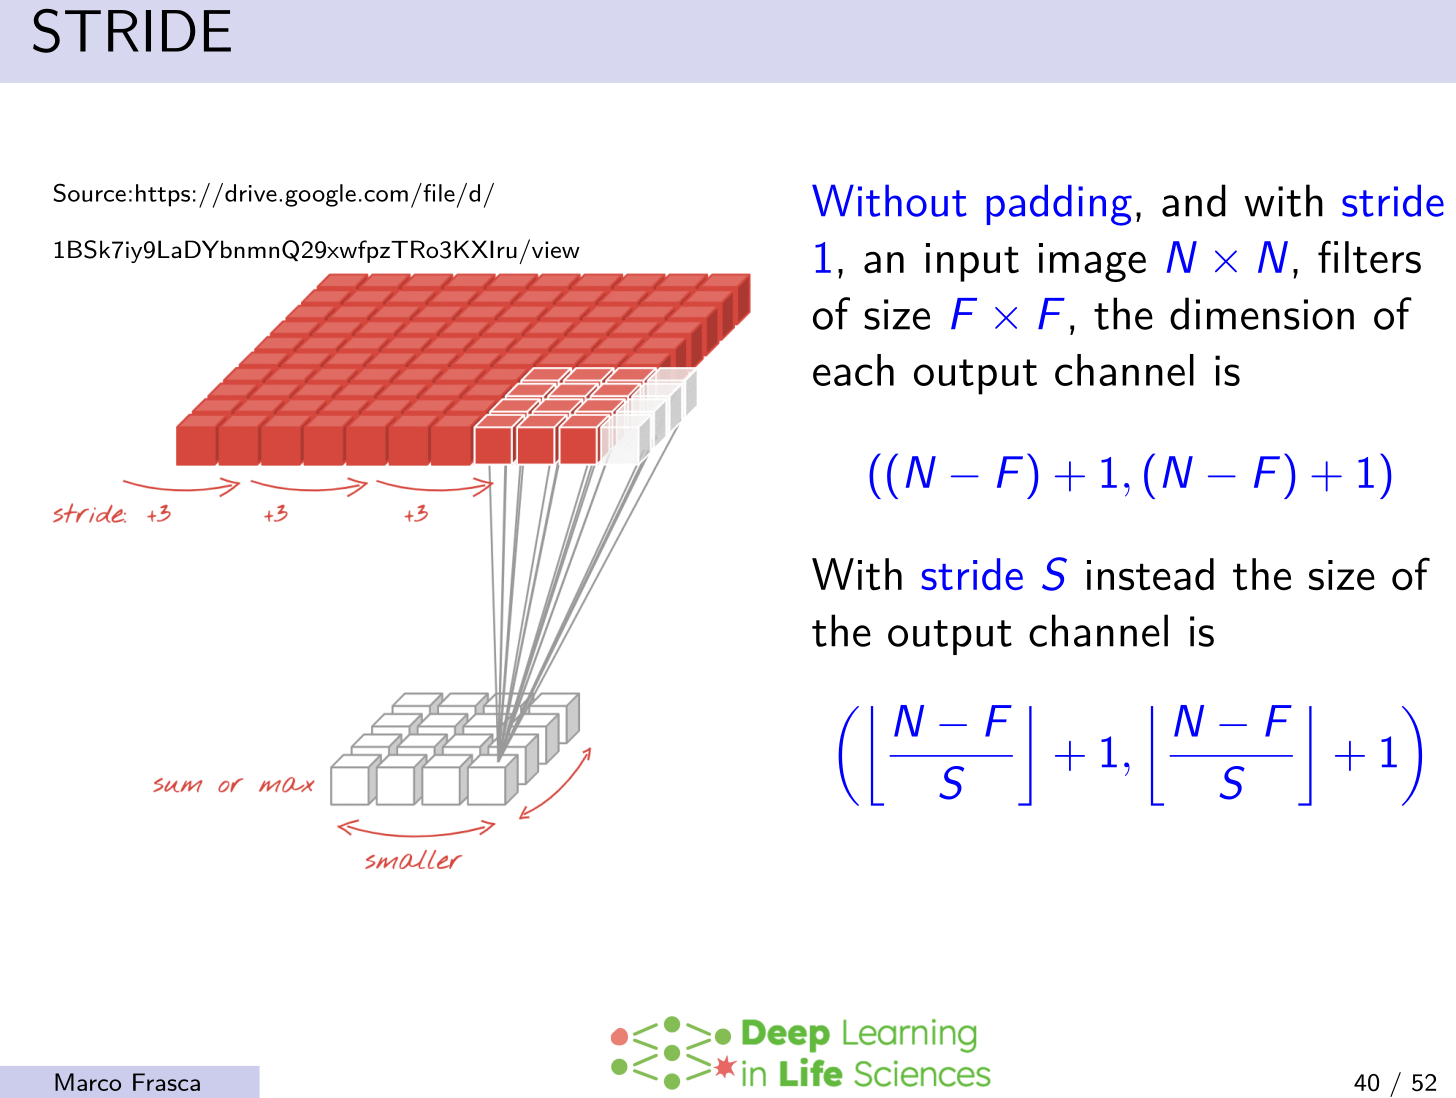

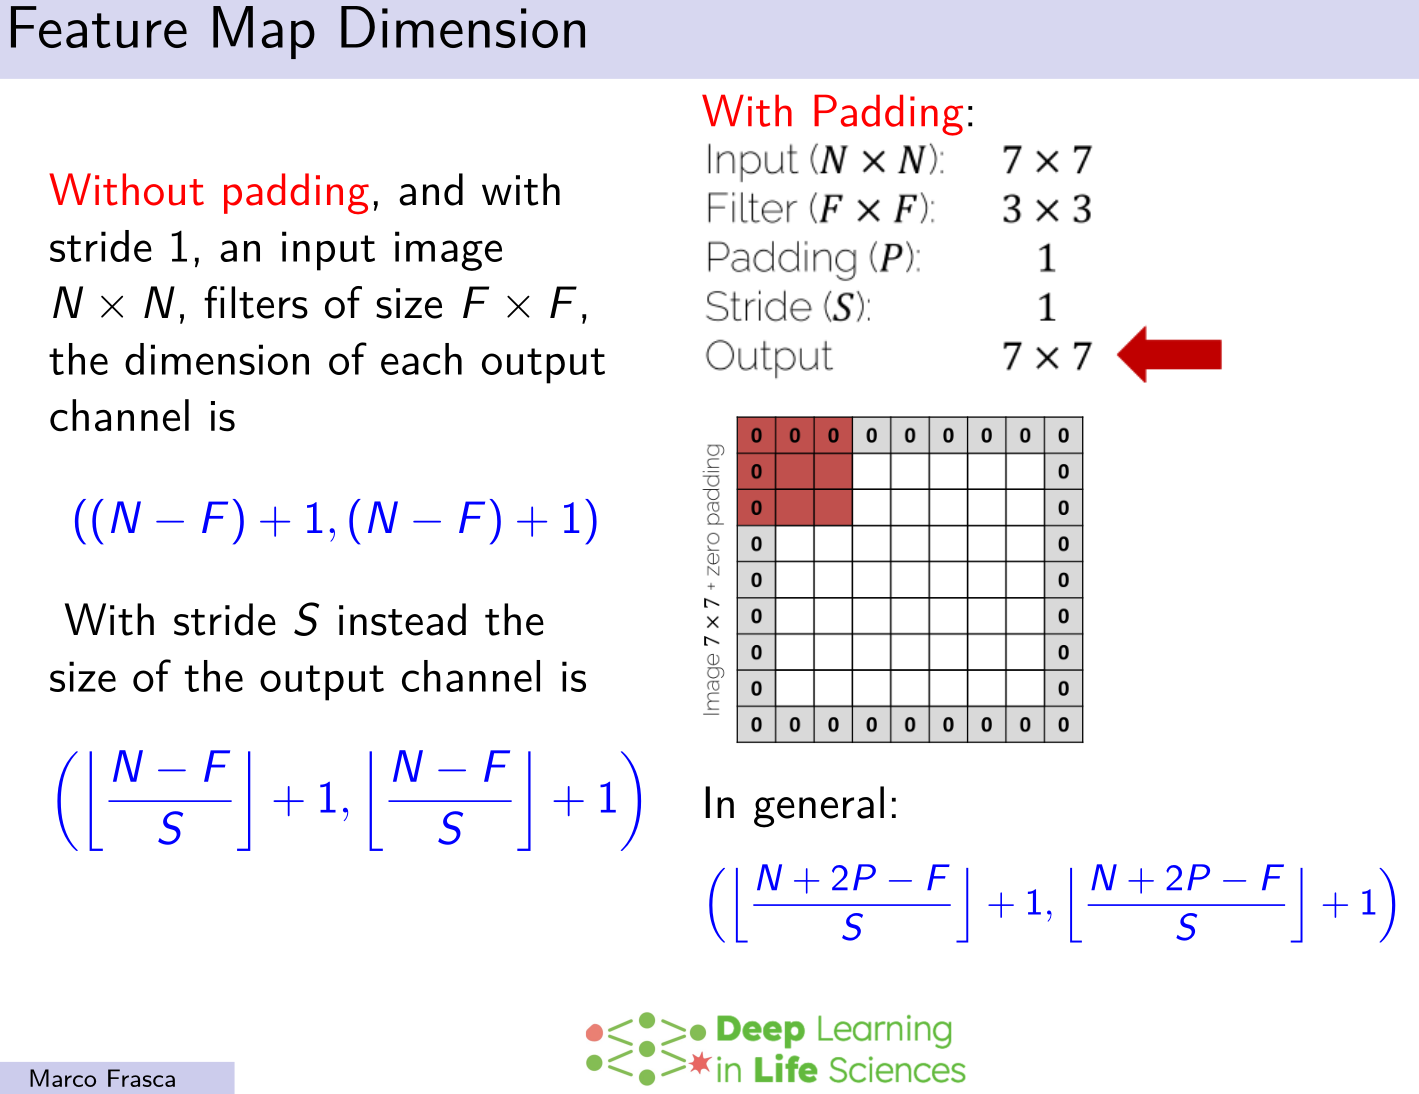

# 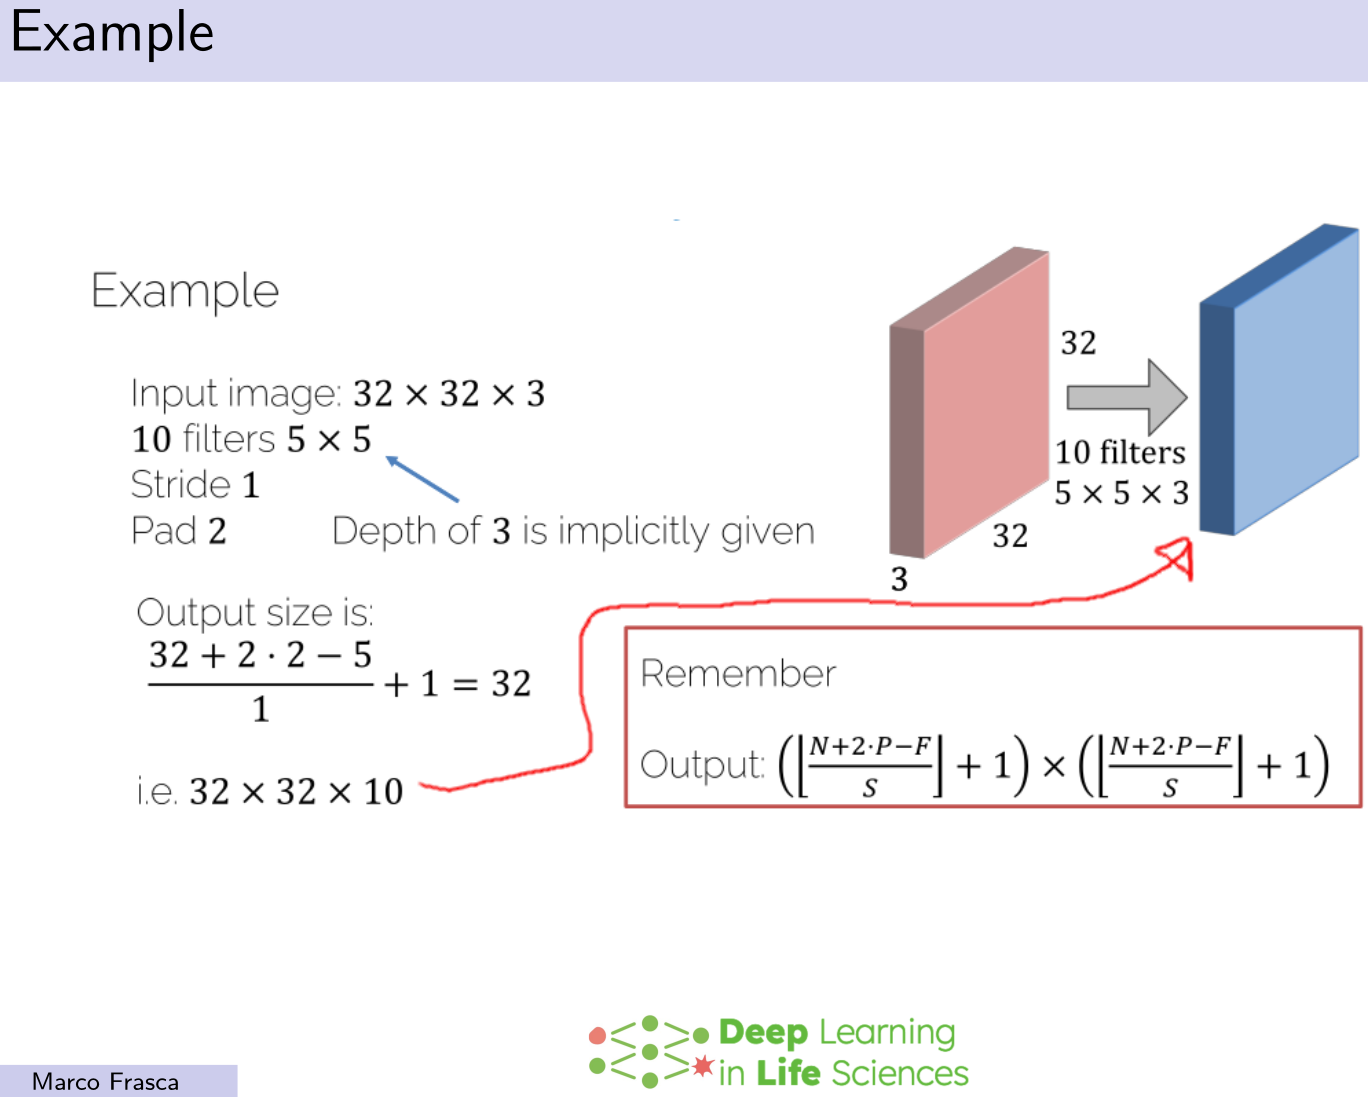

## **POOLING**

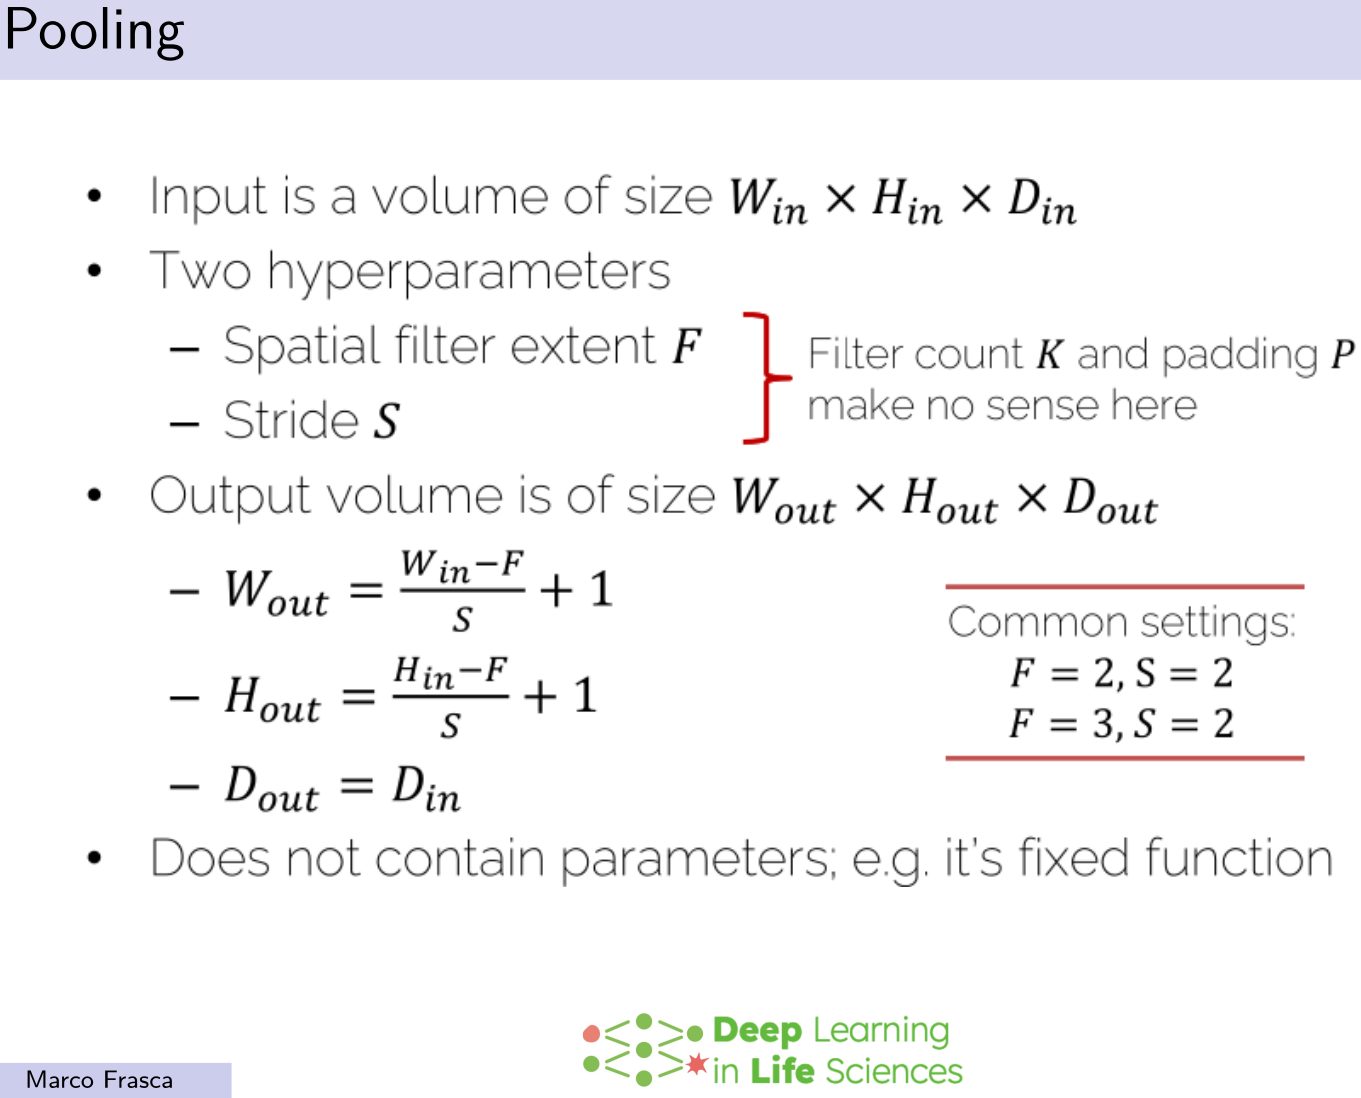

# **Implementing a CNN in Pytorch**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision  #to get the MNIST dataset


import numpy as np
import matplotlib.pyplot as plt

# MNIST image classification
## MNIST (Modified National Institute of Standards and Technology) dataset contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing.
* #### The images are grayscale, 28x28 pixels with values in [0,255].
* #### Images belongs to 10 different classes, the digits from 0 to 9
### AIM: learn a ML model to infer the class of an image

## Loading data
### PyTorch, with its corresponding image library, TorchVision, offers a number of utilities to streamline dataset storage, loading, and preprocessing. We'll start by using TorchVision to download the MNIST dataset
#### class  torchvision.datasets.MNIST
#### Parameters:
* root (string) – Root directory of dataset where MNIST/raw/train-images-idx3-ubyte and MNIST/raw/t10k-images-idx3-ubyte exist.

* train (bool, optional) – If True, creates dataset from train-images-idx3-ubyte, otherwise from t10k-images-idx3-ubyte.

* download (bool, optional) – If True, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.

* transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop

* target_transform (callable, optional) – A function/transform that takes in the target and transforms it.

In [ ]:
#get and format the training set
from torchvision.transforms import ToTensor, Normalize, Compose
## defining a pre-processing tranformation
# ToTensor() converts images or numpy.ndarray to tensors
# Normalization with mean 0 and std 1
my_preprocess = Compose([ToTensor(),
                        Normalize((0,), (1,))])


mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=my_preprocess)

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=my_preprocess)


#In case we need higher precision,
#  DoubleTensor is 64-bit floating point and FloatTensor is 32-bit floating point number
#x_train=mnist_trainset.data.type(torch.DoubleTensor)
print(mnist_trainset.data.size()) # train data
print(mnist_trainset.targets.size()) # labels

print("\nNumber of Targets :",len(np.unique(mnist_trainset.targets)))
print("Train targets Values :", np.unique(mnist_trainset.targets),"\n")

print(mnist_testset.data.size()) # test data
print("Test targets Values :", np.unique(mnist_testset.targets),"\n")

100%|██████████| 9912422/9912422 [00:00<00:00, 85224945.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38152974.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51056745.02it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19069598.37it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])

Number of Targets : 10
Train targets Values : [0 1 2 3 4 5 6 7 8 9] 

torch.Size([10000, 28, 28])
Test targets Values : [0 1 2 3 4 5 6 7 8 9] 



### Let's have a look at a the first training image.

Image 0 is a 5


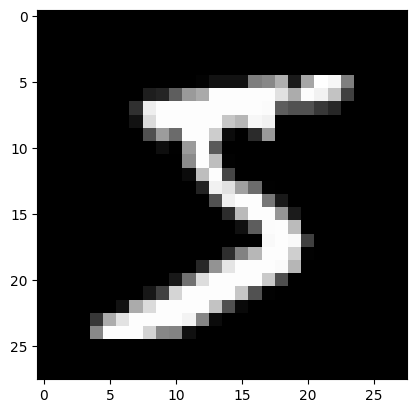

In [ ]:
print(f"Image {0} is a {mnist_trainset.targets[0]}")
plt.imshow(mnist_trainset.data[0], cmap='gray')
plt.show()

In [ ]:
# possibly extract a validation dataset
from torch.utils.data import random_split
val_size = 10000

# for reproducibility
torch.manual_seed(1)

train_size = len(mnist_trainset) - val_size
train_data, val_data = random_split(mnist_trainset, [train_size, val_size])
len(train_data), len(val_data)

(50000, 10000)

### **DataLoaders**

We often want to load our data in __batches__ while training, typically in a random or __shuffled__ order. PyTorch provides a `DataLoader` class to handle the process of fetching data from a `Dataset` object, including shuffling and custom batch collation.

In [ ]:
# we'll use a batch size of 128 for training our network
batch_size = 128

# initialize a DataLoader object for each dataset
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_data,
                                               batch_size=batch_size,
                                               num_workers=2)
test_dataloader = torch.utils.data.DataLoader(mnist_testset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=2)



# grab the first batch from one of our DataLoader objects
example_batch_img, example_batch_label = next(iter(train_dataloader))

# inputs and labels are batched together as tensor objects
print(f"Batch inputs shape: {example_batch_img.shape}, Batch labels shape: {example_batch_label.shape}")

Batch inputs shape: torch.Size([128, 1, 28, 28]), Batch labels shape: torch.Size([128])


min value tensor(0.)
max value tensor(1.)
Mean tensor(0.1298)
Std deviation tensor(0.3082)


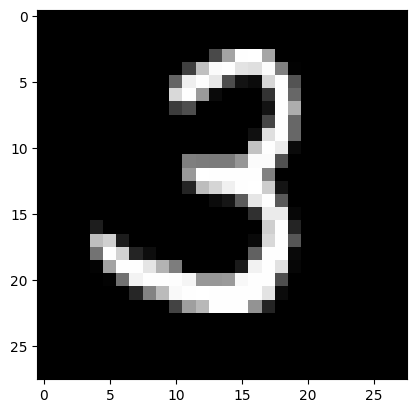

In [ ]:
# sanity check for training data
imgs, lbls = next(iter(train_dataloader))
imgs[7].data.shape
print("min value", imgs.data.min())
print("max value",imgs.data.max())
print("Mean",imgs.data.mean())
print("Std deviation",imgs.data.std())
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

## **Convolutional Layers in Pytorch**
### A convolutional layer operates a convolution between the input and kernel and adds a scalar bias to produce an output.
* #### The two types of parameters of a convolutional layer are the *kernel* and the scalar *bias*.
* #### When training models based on convolutional layers, we typically initialize the kernels randomly, just as we would do with a fully-connected layer


### For 2D convolution, the case of an image, the class to use is
#### `torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)`
* #### Link to [docs](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
* ### MAIN PARAMETERS
1. #### **in_channels** is used as several channels in the input image (for MNIST we have just one, since images are grayscale)
2. #### **out_channels** is used as the number of channels produced by the convolution (number of feature maps to produce or, in ther words, the number of filters/kernels)
3. #### **kernel_size** is used to define the size of the convolving kernel
4. #### **stride** is used to control the stride of the convolution, can be a single number, or a tuple.
    * The default value of the stride is 1
5. #### **padding** is used to control the amount of padding applied to the input
    * It can be either string, e.g., "same" for same padding, or a tuple of giving the amount of implicit padding. The default value of padding is 0

### We will use two convolutional layers with 32 and 64 filters, resp.,  and valid padding, followed by a max pooling layer and two dense/linear layers (with dropout). Softmax activation + Cross Entropy are used to deal with the multiclass classification

## **Pooling**
### To add a max-pooling layer use
#### `torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, ...)`
* #### Link to [docs](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)


## DROPOUT
#### During training, randomly zeroes some of the elements of the input tensor with probability p. The zeroed elements are chosen independently for each forward call and are sampled from a Bernoulli distribution with prob p.

### `torch.nn.Dropout**(p=0.5, ...)`
* #### Link to [docs](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)

#### It is an effective technique for regularization and preventing overfitting

# **Defining the CNN Class**
* ### When defing the layers of our model, and their corresponding activation functions, we have two possibilities:
1. #### using layers from `torch.nn` to be set in the constructor
2. #### using functions from `torch.nn.funtional` in the `forward` method



In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size = 3,
                               stride=1,
                               padding=0)
        # dim (28-3)/1 +1 = 26
        #  feature map dim 26x26x32
        ### Alternative to line 26: uncomment next line and line 27,
        ###   and commment line 26 to
        ###   use torch.nn instead of torch.nn.functional
        #self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # dim 24 x 24 x 64
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # dim 12x12 x 64, 'same' = 9216
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #x = self.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2d(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
#Creating the model
model = CNN()
print(model)

# calling the method on one batch
it = iter(train_dataloader)
X_batch, y_batch = next(it)
print(model.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
torch.Size([128, 10])


In [ ]:
# moving data and model to GPU
import torch
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
print(dev)
device = torch.device(dev)


cuda:0


In [ ]:
## moving the model on GPU
model.cuda()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Training the model
## `model.train()` tells the interpreter that you are training the model
   #### This helps inform layers such as Dropout and BatchNorm, which are designed to behave differently during training and evaluation.

In [ ]:
# Computing the accuracy of a test set
def evaluate(model, test_loader, error):
#model = mlpinplace=False
    correct = 0
    cur_loss = 0;

    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
        output = model(test_imgs)
        loss = error(output, test_labels)
        cur_loss+=loss.item()
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    return cur_loss/len(test_loader.dataset), correct/len(test_loader.dataset)



#training the model
def fit(model, train_loader, error, test_loader, epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)#,lr=0.001, betas=(0.9,0.999))


    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        cur_loss = 0;
        correct = 0
        for X_batch, y_batch in train_loader:
            # moving data to GPU
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            output = model(X_batch)
            loss = error(output, y_batch)
            cur_loss+= loss.item()
            loss.backward()
            optimizer.step()

        train_losses.append(cur_loss/len(train_loader.dataset))

        test_loss, _ = evaluate(model, test_loader, error)
        test_losses.append(test_loss)
        print(f'Epoch : {epoch},  train loss:{train_losses[-1]}, test loss:{test_losses[-1]}')

    return train_losses, test_losses

# **Loss Function**
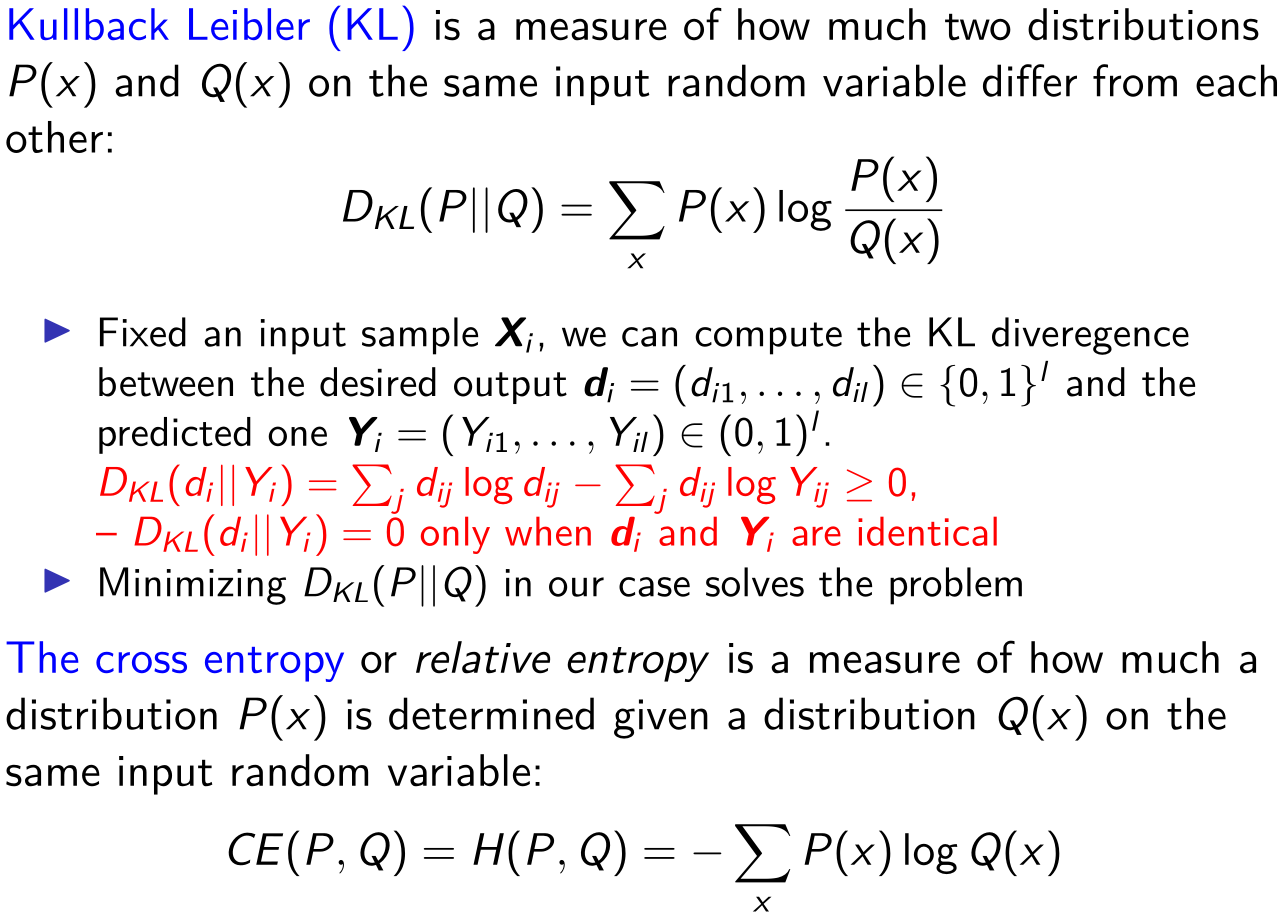

In [ ]:
epochs = 15
error = nn.CrossEntropyLoss() # Loss for multiclass classification
train_losses, test_losses = fit(model,train_dataloader, error, test_dataloader, epochs)

Epoch : 0,  train loss:0.004997666164636612, test loss:0.0023830928433686495
Epoch : 1,  train loss:0.0020023926012217997, test loss:0.0015639785517007113
Epoch : 2,  train loss:0.0013880847574025393, test loss:0.0011246581701561808
Epoch : 3,  train loss:0.001046690106987953, test loss:0.0009065193249611184
Epoch : 4,  train loss:0.0008280146886408329, test loss:0.000725620188890025
Epoch : 5,  train loss:0.0006840682437643409, test loss:0.0006445034509408288
Epoch : 6,  train loss:0.0005929356452822685, test loss:0.0005651242174673825
Epoch : 7,  train loss:0.0005195994505472481, test loss:0.0005371927463449538
Epoch : 8,  train loss:0.0004646397164463997, test loss:0.00045585969827370717
Epoch : 9,  train loss:0.0004218169538117945, test loss:0.0004553223791648634
Epoch : 10,  train loss:0.0003813321795873344, test loss:0.0004391598923015408
Epoch : 11,  train loss:0.0003473547409195453, test loss:0.0004017147862468846
Epoch : 12,  train loss:0.0003259023023582995, test loss:0.00040

## Plotting training and testing losses

<Figure size 640x480 with 0 Axes>

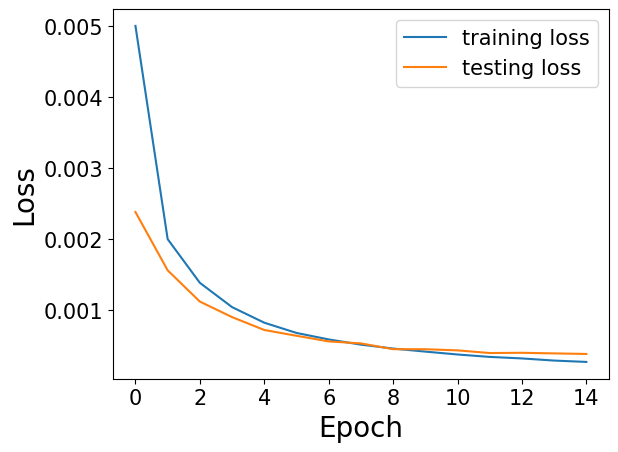

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label="testing loss")
plt.legend(fontsize=15)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure()

# Training Accuracy

In [ ]:
loss, acc = evaluate(model, train_dataloader, error)
print(f"Train Accuracy:{acc}, Train loss:{loss}")

Train Accuracy:0.9899399876594543, Train loss:0.0002486897738929838


## Test accuracy

In [ ]:
loss, acc = evaluate(model, test_dataloader, error)
print(f"Test Accuracy:{acc}, Test loss:{loss}")

Test Accuracy:0.9847999811172485, Test loss:0.0003768727745860815


# Validation Accuracy

In [ ]:
loss, acc = evaluate(model, val_dataloader, error)
print(f"Validation Accuracy:{acc}, Validation loss:{loss}")

Validation Accuracy:0.9820999503135681, Validation loss:0.0004203415491851047


# Exercise
### Use the train and the validation data to select the best model configuration. In particular try different filter sizes (e.g., 3, 4, 5), a different poling layer (e.g., mean pooling), different dropout rates (e.g., 0, 0.1, 0.25).
* #### try for instance one hyperparameter at a time
* #### fix a grid for your hyperparameter, train on the remaining training set, and evaluate on the validation set we have already extracted in previous cells
* #### verify the performance of the selected model (the one with best validation accuracy) on the test data

# Homework assignments (For who needs an exam grade)

### We are given a dataset containing 510 images which are categorized according two main characteristics/properties: “C1” and “C2”. The following inputs are available:
* #### `input image', a 110 × 110 × 3 real-valued tensor. The last dimension denotes the number of input channels; the images belong to different combinations of the two properties C1 and C2. For C1 and C2 we have 5 and 6 possible values, respectively;  among the 30 possible couples (C1,C2), we have images for only 24 of them. We have around 20 samples (little more or less) for each of the available couples;  values in each tensor entry are integers in [0, 255];
* #### C1, string, the value for the C1 property. 5 possible values;
* #### C2, string, the value for the C2 property. 6 possible values.

### Design a deep neural network model to predict the class of an image, given by the couple (C1,C2).

### Provide a sketch of each of the following points, then implement your solution.
1. MODEL: Which architecture do you consider the most appropriate for this task, and why;
2. INPUT:
* After a potential preprocessing step, which is the input of the model, and
how is it represented;
3. OUTPUT: How would you design the output layer and why;
4. LOSS: Which loss function would you use to train your model and why;
5. MODEL CONFIGURATION:
 Model composition (composition of layers, regardless their number,
or their dimension, which can be object of tuning)
6. MODEL EVALUATION: How would you assess (in which setting) the
generalization capabilities of the model on unseen data?


In [ ]:
## HERE mount your drive and go to the path where data can be found
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
## go to your datapath
%cd /content/drive/MyDrive/INSEGNAMENTI/4EU+/

/content/drive/MyDrive/INSEGNAMENTI/4EU+


In [ ]:
# Here you should see the desired files
%ls

airline-passengers.csv  input.pkl                         stride.png
data/                   Lecture2_4EUplus_lab_colab.ipynb  Untitled0.ipynb
example.png             Lecture2_4EUplus_lab_v2.ipynb
featureMap.png          pooling.png


# **Input data**
### To get the input data, download the file `input.zip`, which contains a pickle archive `input.pkl`, then type:  

In [ ]:
import pickle as pk
# Open the pickle data
with open('input.pkl', 'rb') as f:
  data = pk.load(f)

images = data['imgs']
C1 = data['C1']
C2 = data['C2']
print(f"length image:{len(images)}")
print(f"length C1:{len(C1)}")
print(f"length C2:{len(C2)}")

length image:510
length C1:510
length C2:510



# *images*, *C1* and *C2* are related lists:
* #### images[i] a numpy.ndarray containing the (110,110,3) image tensor;
* #### C1[i] is the corresponding C1 poperty;
* #### C2[i] is the corresponding C2 property.

# **RECURRENT NEURAL NETWORKS**
### Let's briefly recap the concept of RNNs, and sketch two RNN models: LSTMs and GRUs


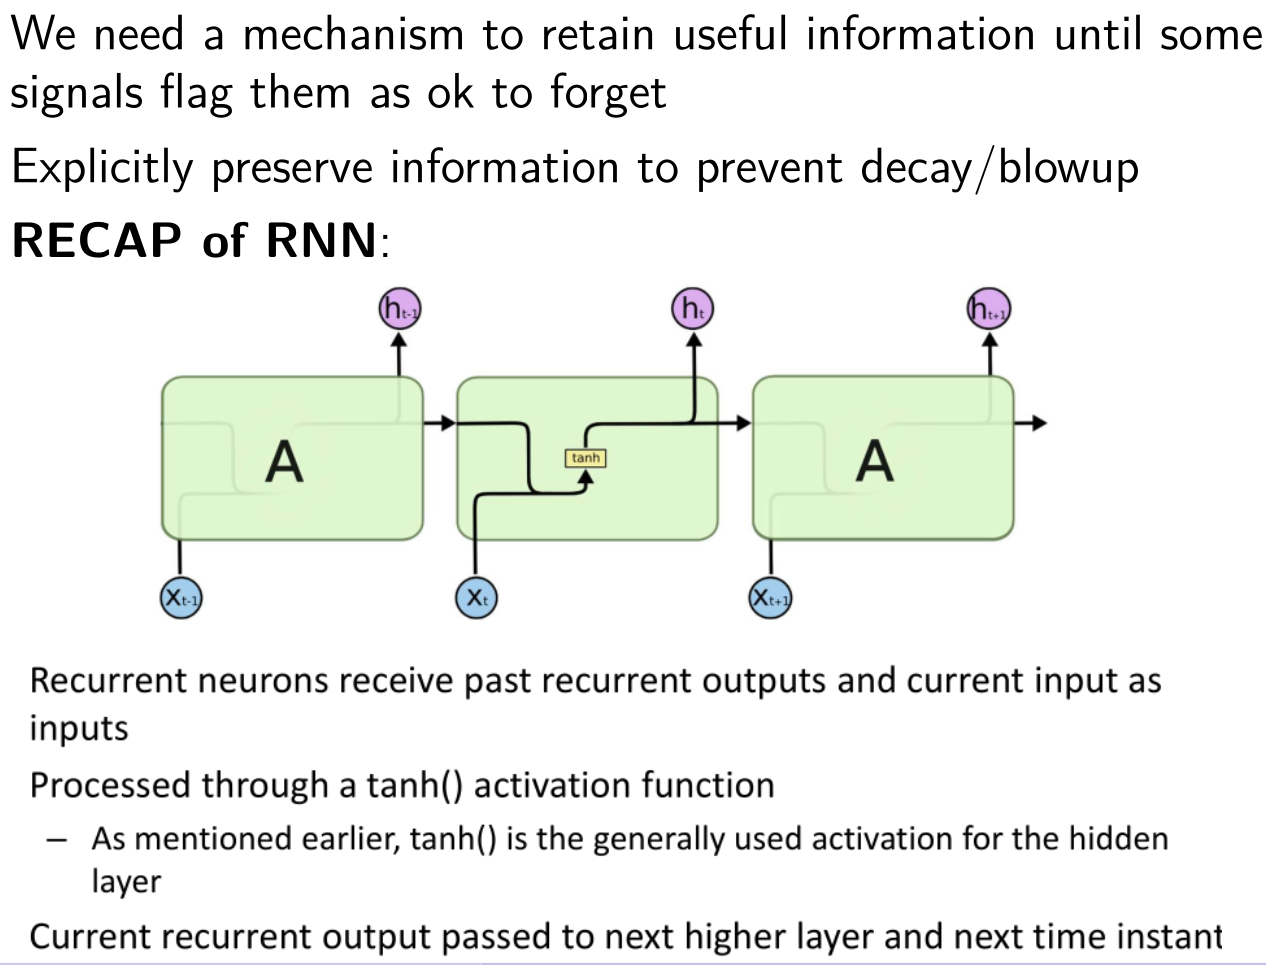

# **LONG SHORT-TERM MEMORIES (LSTMs)**
Hochreiter, S., and Schmidhuber, Jurgen. (1997). Long
short-term memory. Neural Computation, 9(8), 1735–1780.
## A well-know RNN model
* ### They are based on the concept of *gates*
    * #### To regulate what information the cell can remove or add to the cell memory

# **GATE**


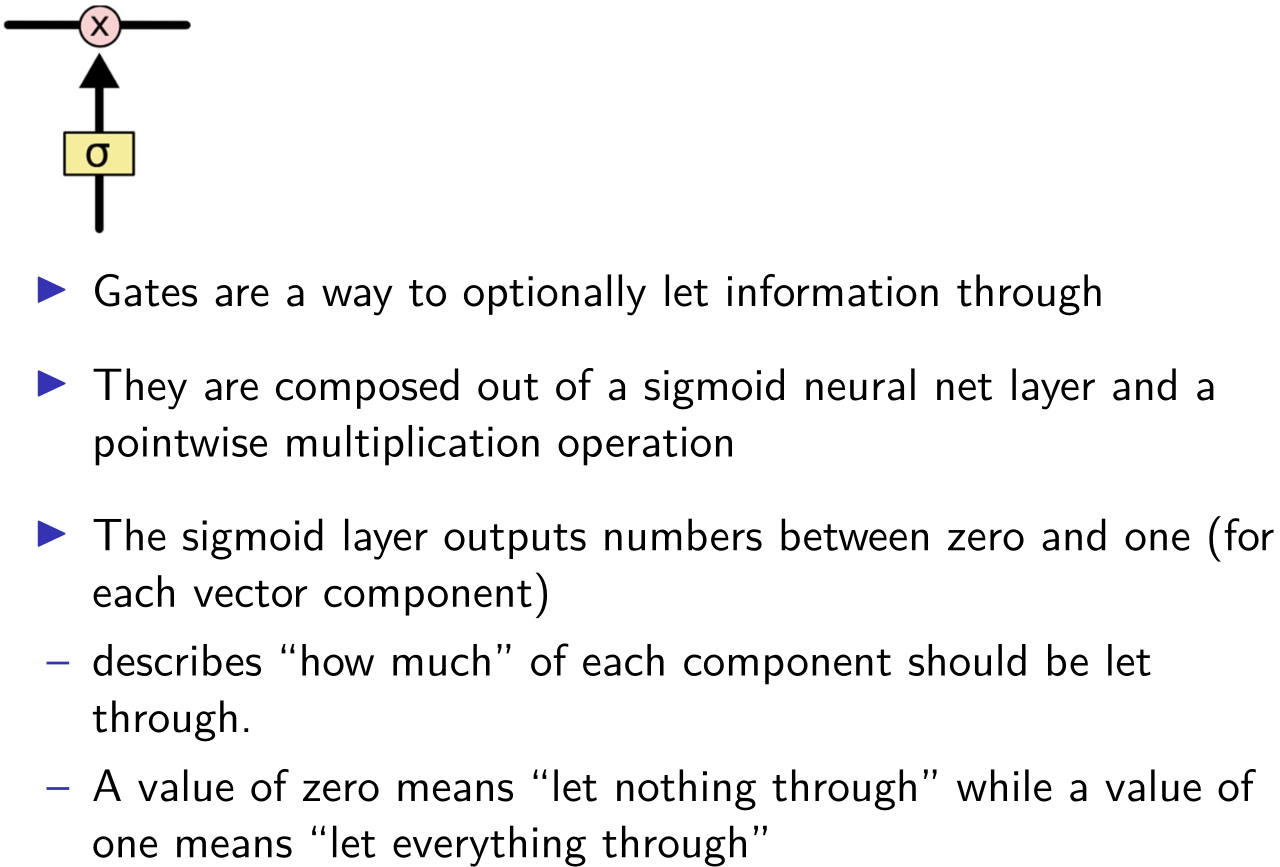

# **LSTM CELL STRUCTURE**

### FORGET GATE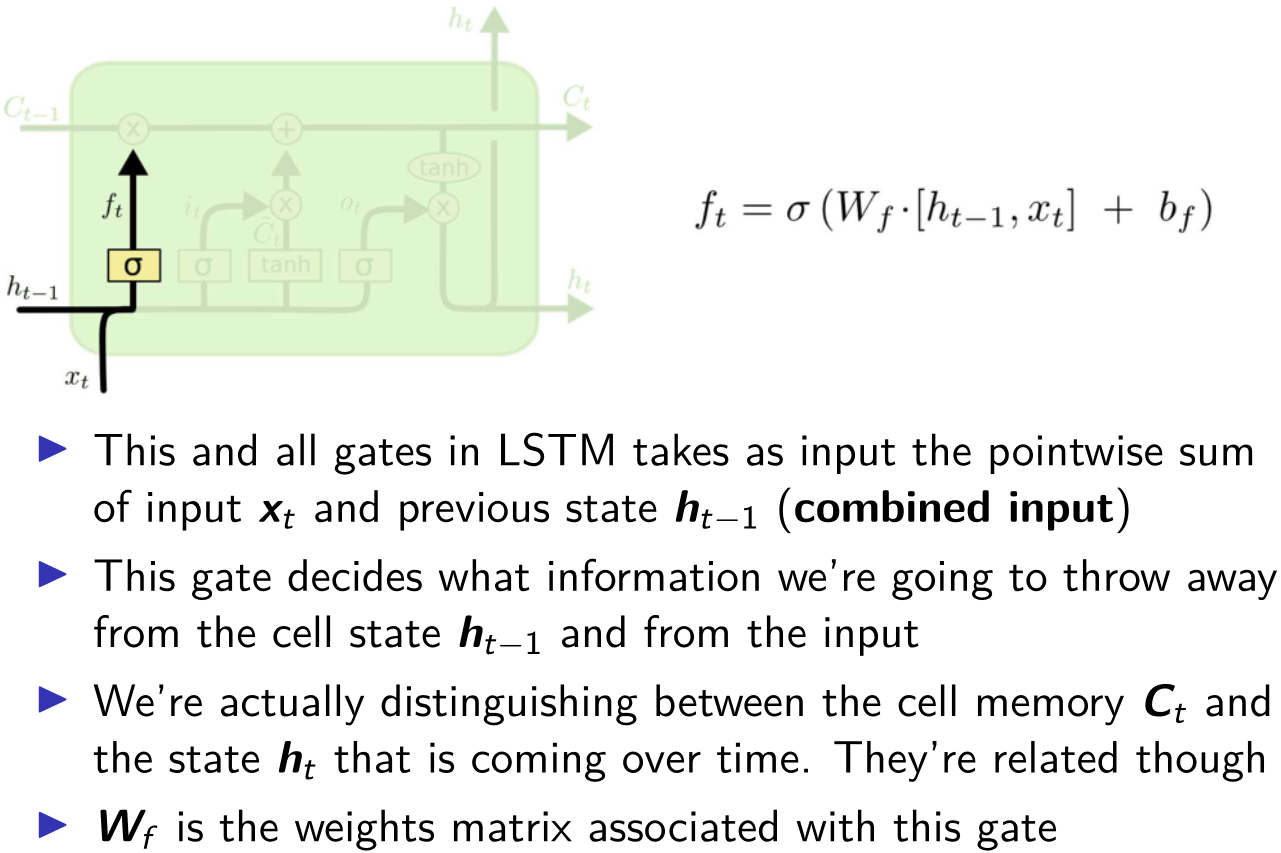

### INPUT GATE

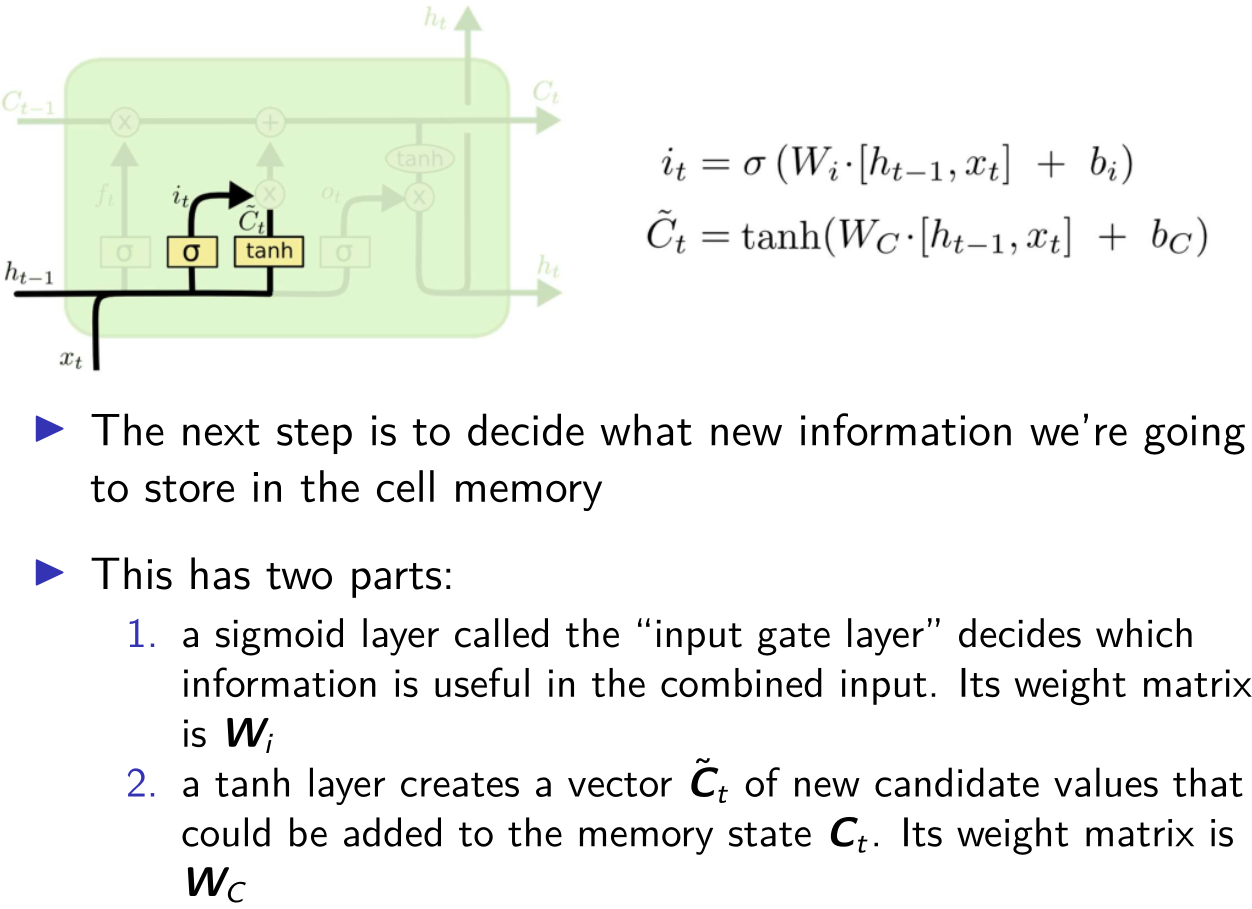

### MEMORY CELL UPDATE

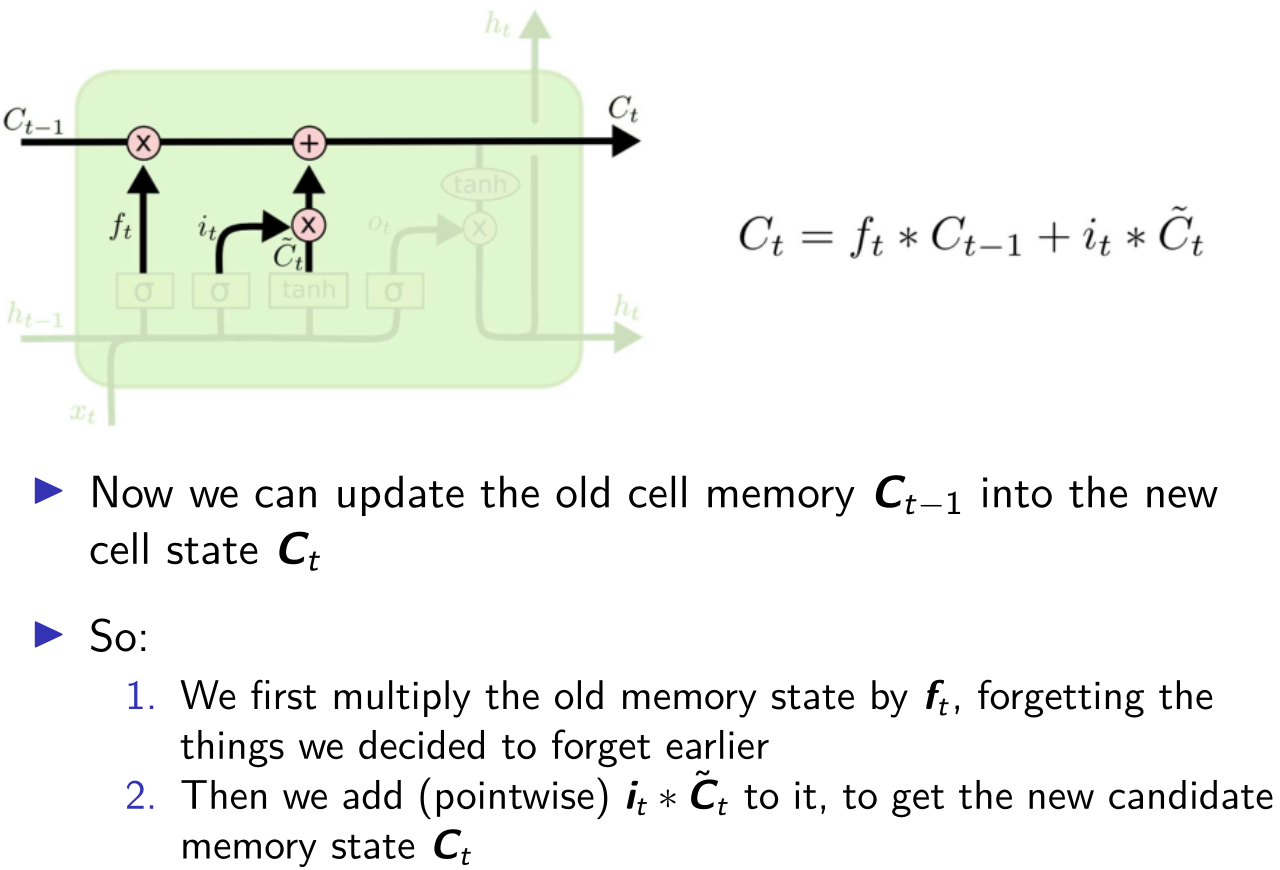

### LSTM OUTPUT and OUTPUT GATE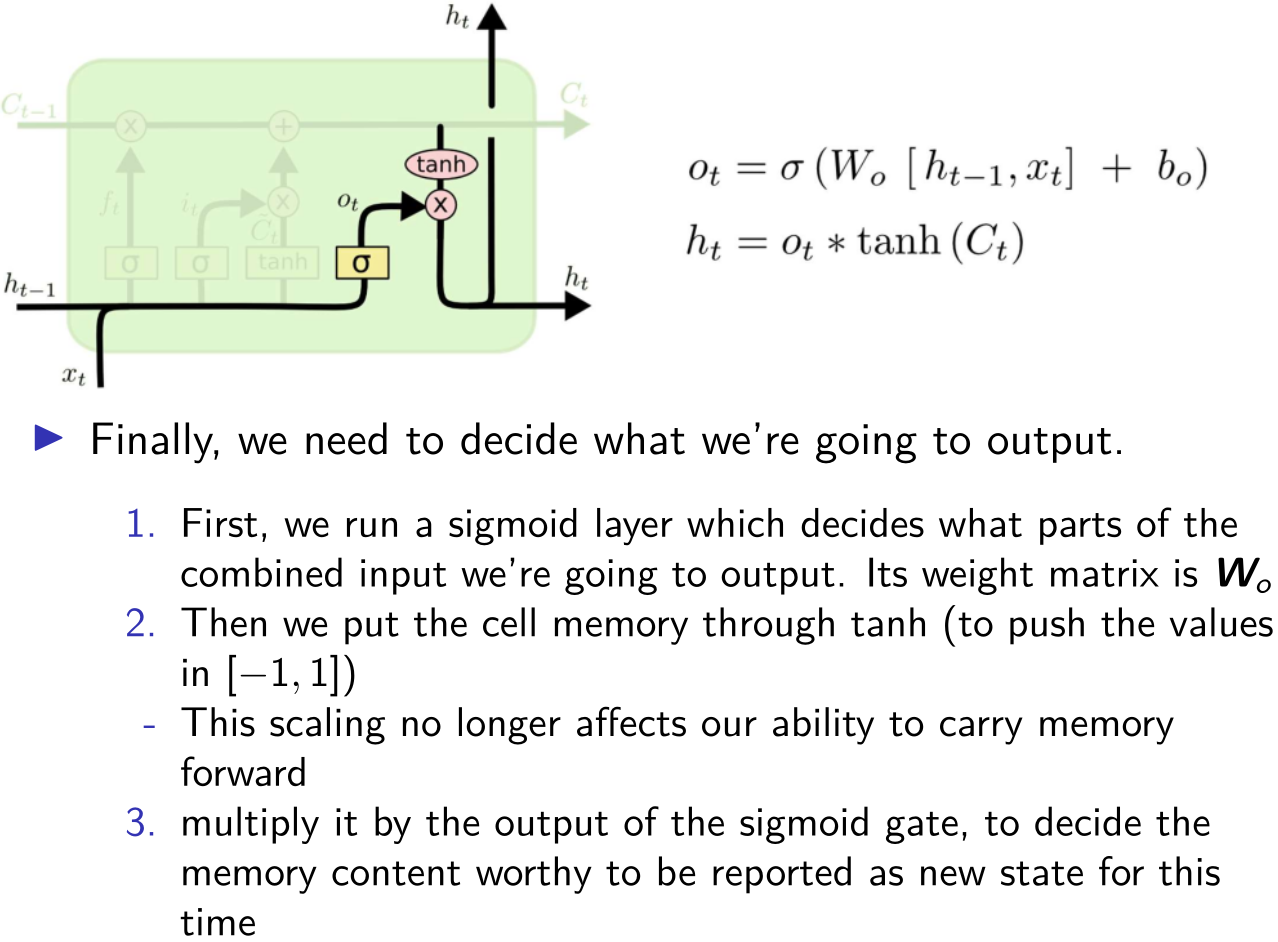

### LSTM SUMMARY

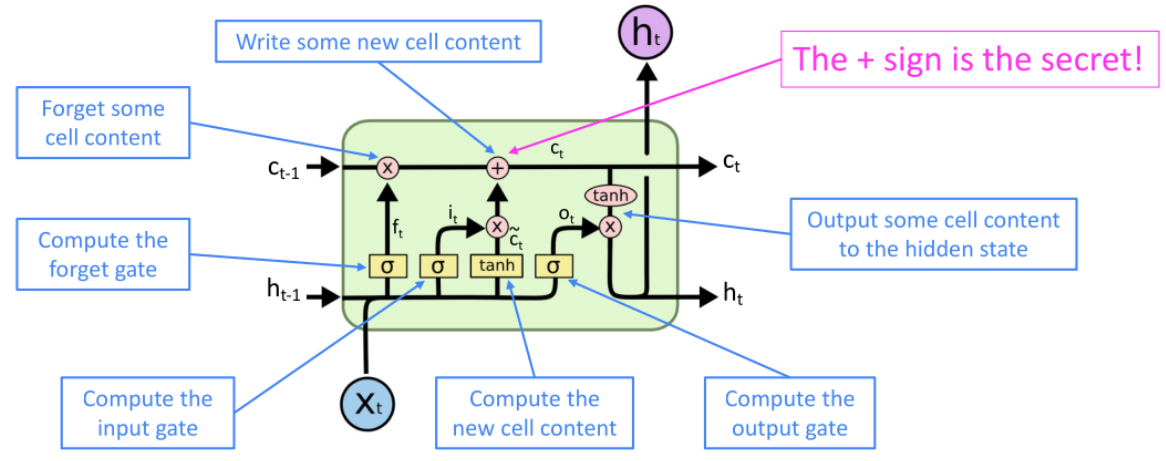

## We don't go through details, but there exists several LSTM variants
* #### one of the most used one is the Gated Recurrent Unit (GRU)
Cho, K., van Merrienboer, B., et al. (2014). ”Learning Phrase
Representations using RNN Encoder-Decoder for Statistical
Machine Translation”. arXiv:1406.1078

# **GRU**

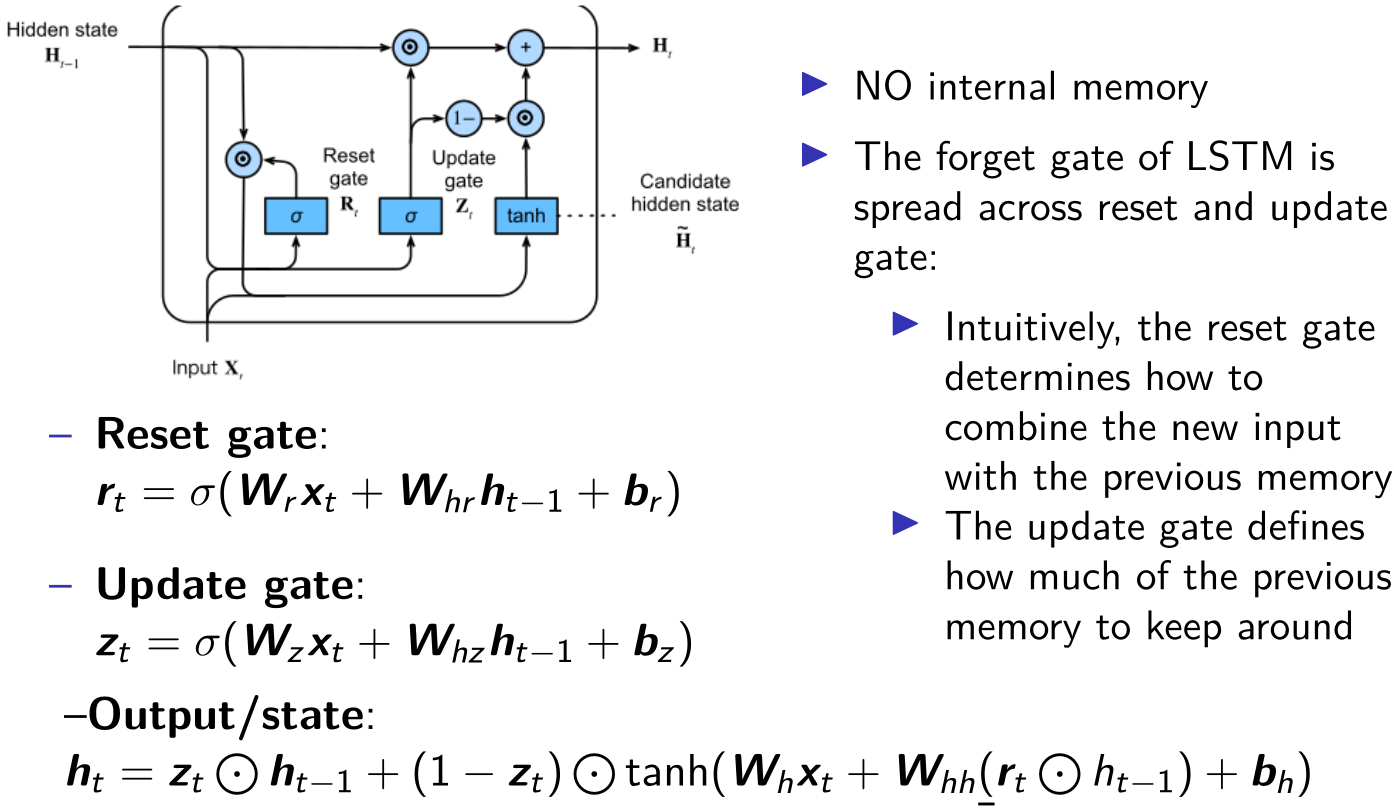

# LSTM to Predict Time Series

## We try to figure out how LSTM can be used to build a time series prediction on the international airline passengers prediction problem.
* [Source](https://www.kaggle.com/code/rakannimer/air-passenger-prediction/input),[Source2](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)
* #### This is a problem where  the task is to predict the number of next month international airline passengers in thousands.
* #### The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
* #### **Task**. Given the number of passengers in the recent months, what is the number of passengers we can expect for the next month?
   * The dataset has only one feature: The number of passengers.



## Reading data
* #### Save the file as `airline-passengers.csv` in your local directory. Il looks like the following.
* #### Being the data are arranged in chronological order, you can retain only the number of passenger, and make a single-feature time series


"Month","Passengers"

"1949-01",112

"1949-02",118

"1949-03",132

"1949-04",129


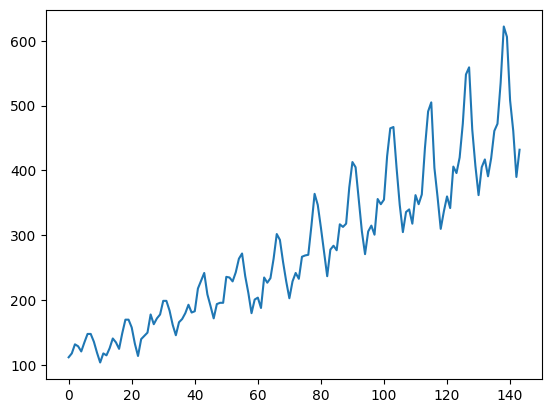

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('airline-passengers.csv')
ts = df[["Passengers"]].values.astype('float32')

plt.plot(ts)
plt.show()

#### Since with this example we want to illustrate the LSTM usage, we skip some preprocessing steps typically applied to time series data.

#### To assess the predictive capability of the model, the time series is split into training and test sets, without shuffling. The first part of time series is used as training data, and the remaining will be used as the test set.

In [ ]:
# fraction of training
tr_frac = 0.67
train_size = int(len(ts) * tr_frac)
test_size = len(ts) - train_size
train, test = ts[:train_size], ts[train_size:]

### Time series prediction is typically perfomed on a window. Given measurements from time *t-s* to time *t*, we are interested in predicting the measurement for time *t+1*.
* #### The size *s* of the temporal window determines how much past is allowed to consider at when making the prediction. The so-called *look-back* period.
* #### Moreover, not only the measurement at time *t+1* but also the previous ones till t-s+1 are retained, because useful for training (remind the BPTT setting)
   * #### So we have overlapping windows
### Let's build the data

In [ ]:
import torch

def make_data(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

## We first try loopback 2

In [ ]:
lookback = 2
X_train, y_train = make_data(train, lookback=lookback)
X_test, y_test = make_data(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([94, 2, 1]) torch.Size([94, 2, 1])
torch.Size([46, 2, 1]) torch.Size([46, 2, 1])


<ipython-input-30-c785cbcd0bbe>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


# **Creating the Model**
* #### LSTM docs [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)  

In [ ]:
import torch.nn as nn

class tsModel(nn.Module):
    def __init__(self, hidden_size, bidirectional):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1,
                            hidden_size=hidden_size,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=bidirectional)
        if bidirectional:
          self.linear = nn.Linear(2*hidden_size, 1)
        else:
          self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # The second output is the LSTM cell’s memory, which is not used here.
        x, _ = self.lstm(x)
        # use x[:,-1,:] in case you need to consider only the last timestep hidden state
        x = self.linear(x)
        return x

# TRAINING THE MODEL
### To leverage the usual training loop facility provided by `DataLoader` class, we combine our data into a dataset via `torch.utils.data.TensorDataset()`

In [ ]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

hidden_size = 25
batch_size = 16
bidirectional=False

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

model = tsModel(hidden_size, bidirectional)
optimizer = optim.Adam(model.parameters())
# Since it's a regression problem, we use MSE loss
loss_fn = nn.MSELoss()

n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 300 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.8931, test RMSE 423.3734
Epoch 300: train RMSE 165.8088, test RMSE 359.9914
Epoch 600: train RMSE 115.9159, test RMSE 302.8896
Epoch 900: train RMSE 77.5588, test RMSE 249.7412
Epoch 1200: train RMSE 51.2836, test RMSE 202.7666
Epoch 1500: train RMSE 36.4728, test RMSE 164.2402
Epoch 1800: train RMSE 28.8094, test RMSE 135.6947
Epoch 2100: train RMSE 25.5219, test RMSE 116.9622
Epoch 2400: train RMSE 23.8552, test RMSE 105.2833
Epoch 2700: train RMSE 22.9533, test RMSE 97.5934


# Plotting the Result

96


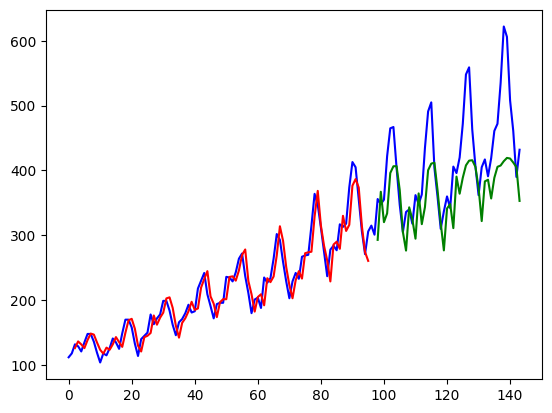

In [ ]:
print(train_size)
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(ts) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(ts) * np.nan
    test_plot[train_size+lookback:len(ts)] = model(X_test)[:, -1, :]
# plot
plt.plot(ts, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# If you want also to try a GRU [here](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU) you can find the docs

# EXERCISE
#### Evaluate the impact of extending the loop-back size, of using a bidirectional LSTM, and of increasing the number of LSTM layers on the model performance.